# AAE364 Grand Prix

This notebook is a go-kart race simulation. You must design the steering and the throttle controller.

![GoKart](fig/grandprix_d.jpg)

## Mathematical Model

You control:
1. The throttle, $V$, which directly controls the velocity of car.
2. The steering angle of the wheel, $\delta$.

You are given:
1. The error along the track direction, $e_y$.
2. The error across the track direction, $e_x$.

The equations of motion are non-linear but can be approximated as linear:

$\dot{\theta} = \dfrac{V}{l} \delta$

$\ddot{x} = \dfrac{V^2}{l} \delta$

$\dot{y} = V$

You are expected to use matlab/python to design a lead-lad or PID compensator.

You will receive full credit, if you controller can successfully drive 30 m on the track.

## Extra Credit

You will receive extra credit by the following table:

1. Top 25 \% of the class who are above 30 m: 3 points extra credit
1. Top 50 \% of the class who are above 30 m: 2 points extra credit
1. Top 75 \% of the class who are above 30 m: 1 points extra credit

## Submission
To submit your script for grading, upload your Controller in a standalone file names 'grandprix_your_name.py' make sure it follows the format below:

```python
class Controller:
  """
  You must design a controller using a PID or lead-lag controller or
  a set or any combination of these controller to design the best
  control system possible that drives the race course without
  leaving the track.
  """
  
  def __init__(self, dt):
    """
    @param dt: the update rate of the controller
    """
    ...
  
  def update(self, error):
    """
    current state:
    @param error: [error_theta, error_x, error_y]
    
    ouput
    @param throttle: the throttle to the motor from 0-1
    @param steering: the steering angle of the vehicle in radians
    """
    ...
    return throttle, steering
```


# Simulation Code

Make sure to install python control if you don't have it.

In [1]:
!pip install control

In [2]:
import numpy as np
import control
import scipy
import matplotlib.pyplot as plt

In [3]:
class SE2:
  """
  This is an implementation of the mathematical group SE2, that represents rigid
  body motions in the plane. We are using it as it allows us to turn the 
  non-linear control problem of driving a car on a plane into a linear control
  problem that you can solve with the methods learned in this class.
  
  @see http://ethaneade.com/lie.pdf
  @see https://www.youtube.com/watch?v=mJ8ZDdA10GY
  """
  
  def from_params(self, v):
    """
    Create group form parameterization.
    v: [theta, x, y]
    """
    theta, x, y = v
    return np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])

  def to_params(self, G):
    """
    Get parameterization of group.
    v = [theta, x, y]
    """
    theta = np.arctan(G[1, 0]/ G[0, 0])
    x = G[0, 2]
    y = G[1, 2]
    return np.array([theta, x, y])
  
  def wedge(self, v):
    """
    This function takes a vector in R^3 and transforms it into an element of
    the lie algebra using the wedge operator.
    
    @param v:
      v[0] : dtheta - rotational rate
      v[1] : ux - velocity in body x frame
      v[2] : uy - velocity in body y frame
    @return The 3x3 matrix in the lie algebra
    """
    dtheta, dx, dy = v
    return np.array([
        [0, -dtheta, dx],
        [dtheta, 0, dy],
        [0, 0, 1]
        ])
  
  def vee(self, Omega):
    """
    This takes an element of the lie algebra
    and transforms it to a vector in R^n using the vee operator.
    
    @param Omega: element of lie algebra
    @return vector in R^3
    """
    theta = Omega[1, 0]
    x = Omega[0, 2]
    y = Omega[1, 2]
    return np.array([theta, x, y])
 
  def exp(self, Omega):
    """
    This is the exponential map that transforms an element of the lie algebra
    se2 to the lie group SE2
    """
    theta = Omega[1, 0]
    u = np.array([Omega[0, 2], Omega[1, 2]])
    if theta < 1e-5:
      A = 1
      B = 0
    else:
      A = np.sin(theta)/theta
      B = (1 - np.cos(theta))/theta
    V = np.array([[A, -B], [B, A]])
    p = V.dot(u)
    return np.array([
        [np.cos(theta), -np.sin(theta), p[0]],
        [np.sin(theta), np.cos(theta), p[1]],
        [0, 0, 1]
    ])
  
  def log(self, G):
    """
    The is the log map that transforms an element in the lie group SE2 to the
    lie algebra se2
    """
    theta = np.arctan2(G[1, 0], G[0, 0])
    if theta < 1e-5:
      A = 1
      B = 0
    else:
      A = np.sin(theta)/theta
      B = (1 - np.cos(theta))/theta
    V_I = np.array([[A, B], [-B, A]])/(A**2 + B**2)
    p = np.array([G[0, 2], G[1, 2]])
    u = V_I.dot(p)
    return np.array([
        [0, -theta, u[0]],
        [theta, 0, u[1]],
        [0, 0, 1]
    ])


def test_SE2():
  """
  Make sure SE2 is working properly.
  """
  G = SE2()
  v = np.array([1, 2, 3])
  assert np.allclose(G.vee(G.wedge(v)), v)
  assert np.allclose(G.vee(G.log(G.exp(G.wedge(v)))), v)
  assert np.allclose(G.to_params(G.from_params(v)), v)
  print('PASS')
  
test_SE2()

PASS


In [58]:
class Sim:
  
  def __init__(self, Controller, dt, tf, verbose=False):
    """
    Setup the sim and load the controller.
    """
    self.G = SE2()
    self.dt = dt
    self.tf = tf
    self.controller = Controller(dt)
    self.data = {
        't': [],
        'theta': [],
        'x': [],
        'y': [],
        'theta_r': [],
        'x_r': [],
        'y_r': [],
        'throttle': [],
        'steering': [],
        'e_theta': [],
        'e_x': [],
        'e_y': []
    }
    
    # reference trajectory parameters
    self.verbose = verbose
    self.radius = 1
    self.width = 0.2
    self.l_cm = 0.01 # distance from center of mass to front wheel
    self.disturbance_mag_xy = 1e-1 # disturbance due to unmodelled effects
    self.disturance_mag_theta = 1e-2

    if self.verbose:
      print('sim initialized')

  def run(self):
    if self.verbose:
      print('sim started')
    
    # randomize disturbance phase
    phi_dist = 0.1*np.pi*np.random.randn()
    
    # put the car at the starting line, facing the right direction
    theta0 = 0
    x0 = self.radius + 0.1
    y0 = 0
    X = self.G.from_params([theta0, x0, y0])
    
    # start reference position as starting line
    theta_r = 0
    
    for t in np.arange(0, self.tf, self.dt):
      # reference trajectory, the race course
      theta, x, y = self.G.to_params(X)
      theta_r += self.controller.desired_speed*self.dt/self.radius
      x_r = self.radius*np.cos(theta_r)
      y_r = self.radius*np.sin(theta_r)
      Xr = self.G.from_params([theta_r, x_r, y_r])
      error = self.G.vee(self.G.log(np.linalg.inv(X).dot(Xr)))
      
      # check if you ran off the track
      if np.abs(np.sqrt(x**2 + y**2) - self.radius) > self.width:
        print('CRASH at time {:10.4f} seconds'.format(t))
        return 0
        
      # add noise
      error += np.random.randn(3)*np.array([1e-2, 1e-2, 1e-2])
      
      # call the controller
      throttle, steering = self.controller.update(error)
      
      # saturate inputs
      if throttle < 0:
        throttle = 0
      if steering > 1:
        steering = 1
      if steering < -1:
        steering = -1
        
      # simulate disturbance in body frame
      disturbance_x = self.disturbance_mag_xy*np.sin(t + phi_dist)*throttle
      disturbance_y = self.disturbance_mag_xy*np.cos(t + phi_dist)*throttle
      disturbance_theta = self.disturance_mag_theta*throttle
      
      dtheta = throttle*np.tan(steering)/self.l_cm + disturbance_theta
      dx = disturbance_x
      dy = throttle + disturbance_y
      
      u = np.array([dtheta, dx, dy])
      dX = self.G.exp(self.G.wedge(u*self.dt))
      X = X.dot(dX)
      theta, x, y = self.G.to_params(X)
      
      self.data['t'].append(t)
      self.data['theta'].append(theta)
      self.data['x'].append(x)
      self.data['y'].append(y)
      self.data['theta_r'].append(theta_r)
      self.data['x_r'].append(x_r)
      self.data['y_r'].append(y_r)
      self.data['throttle'].append(throttle)
      self.data['steering'].append(steering)
      self.data['e_theta'].append(error[0])
      self.data['e_x'].append(error[1])
      self.data['e_y'].append(error[2])


    # convert lists to numpy array for faster plotting
    for k in self.data.keys():
      self.data[k] = np.array(self.data[k])
    
    distance = theta_r*self.radius
    if self.verbose:
      print('sim complete')
      print('you made it: {:10.4f} m'.format(distance))
    
    return distance
 
  def plot(self):
    theta = np.linspace(0, 2*np.pi, 1000)
    plt.figure(figsize=(10, 10))
    plt.plot(
        (self.radius + self.width)*np.cos(theta),
        (self.radius + self.width)*np.sin(theta), 'r--')
    plt.plot(
        (self.radius - self.width)*np.cos(theta),
        (self.radius - self.width)*np.sin(theta),
        'r--', label='track')
    plt.plot(self.data['x'], self.data['y'], 'b', label='vehicle')
    plt.legend()
    plt.axis('equal')

    
    plt.figure(figsize=(10, 30))
    n = 3
    plt.subplot(n, 1, 1)
    plt.plot(sim.data['t'], sim.data['e_x'], label='e_x')
    plt.xlabel('t, sec')
    plt.ylabel('m')
    plt.legend()
    plt.title('cross track error')

    plt.subplot(n, 1, 2)
    plt.plot(sim.data['t'], sim.data['e_y'], label='e_y')
    plt.legend()
    plt.xlabel('t, sec')
    plt.ylabel('m')
    plt.title('along track error')

    plt.subplot(n, 1, 3)
    plt.plot(sim.data['t'], np.rad2deg(sim.data['e_theta']), label='e_theta')
    plt.legend()
    plt.xlabel('t, sec')
    plt.ylabel('deg')
    plt.title('angle error')

    plt.figure(figsize=(10, 20))
    n = 2
    plt.subplot(n, 1, 1)
    plt.plot(sim.data['t'], sim.data['throttle'])
    plt.xlabel('t, sec')
    plt.ylabel('velocity, m/s')
    plt.title('throttle')

    plt.subplot(n, 1, 2)
    plt.plot(sim.data['t'], np.rad2deg(sim.data['steering']))
    plt.xlabel('t, sec')
    plt.ylabel('angle, deg')
    plt.title('steering')

In [59]:
class DiscreteStateSpace:
  """
  Use this class to implement any controller you need.
  It takes a continuous time transfer function.
  """
  
  def __init__(self, H, dt):
    sys = control.tf2ss(control.c2d(H, dt))
    self.x = np.zeros((sys.A.shape[0], 1))
    self.A = sys.A
    self.B = sys.B
    self.C = sys.C
    self.D = sys.D
    self.dt = sys.dt

  def update(self, u):
    self.x = self.A.dot(self.x) + self.B.dot(u)
    return self.C.dot(self.x) + self.D.dot(u)
 
  def __repr__(self):
    return repr(self.__dict__)

## Grading

In [60]:
def score_controller(Controller, dt=0.01, tf=2*np.pi, n=20, verbose=False):
  """
  This function will be used to grade your controller performance.
  """
  distance = []
  for i in range(n):
    sim = Sim(Controller=Controller, dt=dt, tf=tf, verbose=False)
    distance.append(sim.run())
  mean_distance = np.mean(distance)
  if verbose:
    print('AVERAGE DISTANCE {:10.4f} m'.format(mean_distance))
  return mean_distance

## Design your Controller Here

AVERAGE DISTANCE     6.2900 m


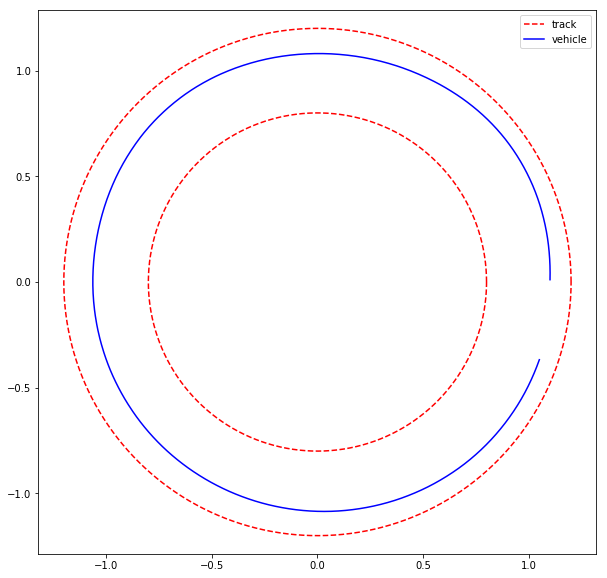

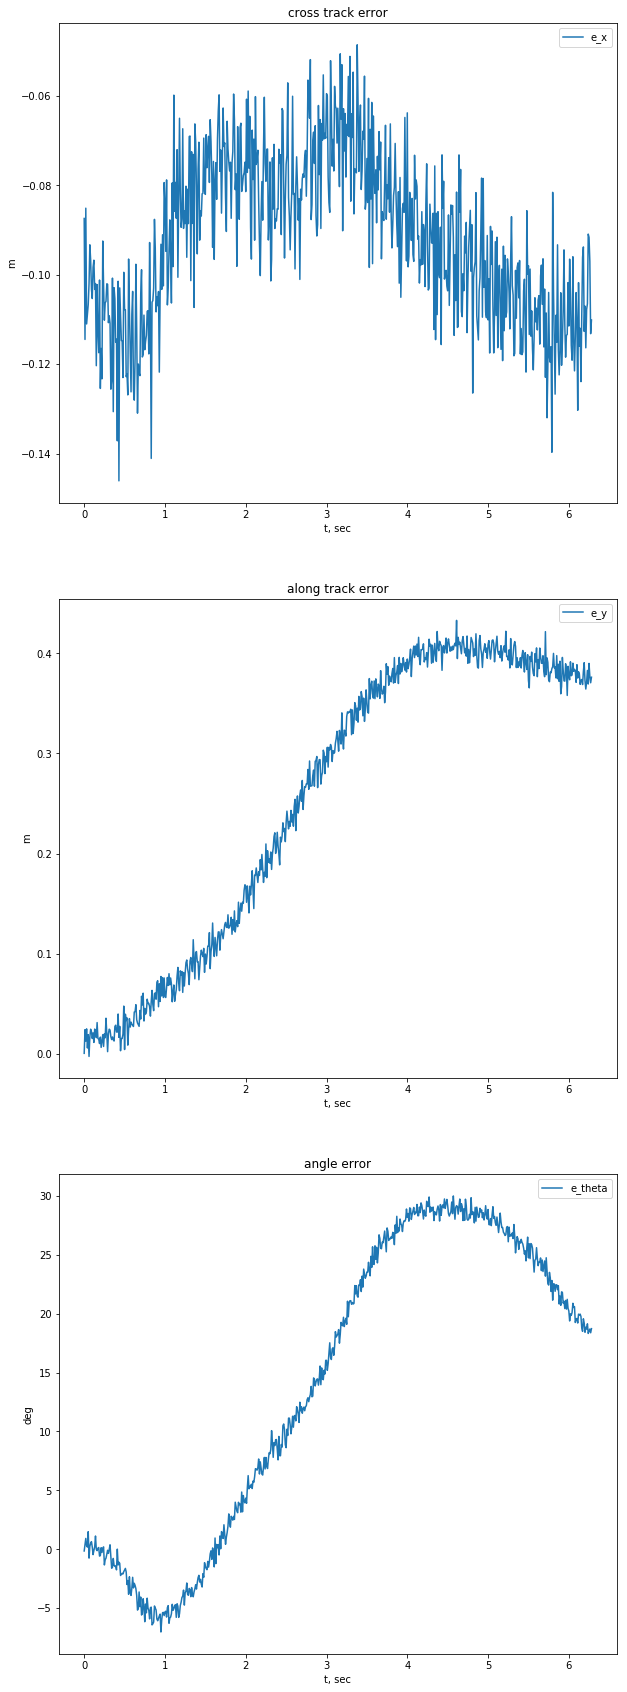

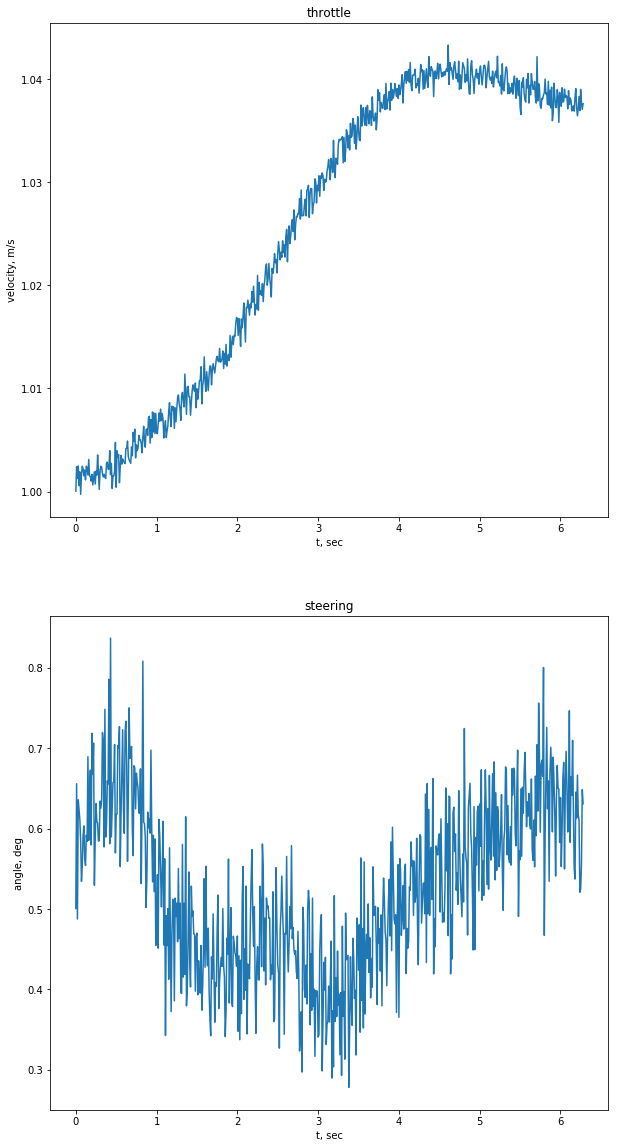

In [67]:
class Controller:
  """
  You must design a controller using a PID or lead-lag controller or
  a set or any combination of these controller to design the best
  control system possible that drives the race course without
  leaving the track.
  """
  
  def __init__(self, dt):
    """
    @param dt: the update rate of the controller
    """
    self.dt = dt

    ###
    ### WRITE YOUR OWN CONTROLLERS HERE
    ###
    s = control.tf([1, 0], [0, 1])
    low_pass = 20/(s+20)
    H1 = 0.1 + 0.0/s + 0.0*s*low_pass
    self.ey_throttle = DiscreteStateSpace(H1, dt)
    
    H2 = 0.1 + 0.0/s + 0.0*s*low_pass
    self.ex_steering = DiscreteStateSpace(H2, dt)
    
    # how fast do you want the reference signal to go
    self.desired_speed = 1
  
  def update(self, error):
    """
    current state:
    @param error: [error_theta, error_x, error_y]
    
    ouput
    @param throttle: the throttle to the motor from 0-1
    @param steering: the steering angle of the vehicle in radians
    """
    etheta, ex, ey = error
    
    ###
    ### WRITE YOUR CODE HERE TO CONTROL THE CAR
    ###    
    throttle = float(self.ey_throttle.update(ey)) + self.desired_speed
    steering = -float(self.ex_steering.update(ex))
    return throttle, steering

np.random.seed(1234) 
mean_distance = score_controller(Controller, verbose=True)
sim = Sim(Controller=Controller, dt=0.01, tf=2*np.pi, verbose=False)
sim.run()
sim.plot()